# Food Image Classification

## Project Objective: Design a CNN classifier for Food identification model

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt # MATPLOTLIB FOR PLOTTING
from matplotlib.pyplot import imread
from scipy.ndimage.filters import convolve
# !pip install opencv-python
import cv2
import os

import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.initializers import HeUniform

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from zipfile import ZipFile

# Specify the path to the zip file
zip_path = '/content/gdrive/MyDrive/Food_101 - Dataset.zip'

# Extract the contents of the zip file
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_data')

# Access the extracted files
extracted_files = ZipFile(zip_path, 'r').namelist()

In [4]:
X = []
y = []
a=1
# list all folders inside train directory
for i in os.listdir('/content/extracted_data/Food_101'):
    print(i)          
    for j in os.listdir('/content/extracted_data/Food_101/' + i):
      # read each image inside train directory one by one
      dummy = cv2.imread('/content/extracted_data/Food_101/' + i + "/" + j)
      dummy = cv2.resize(dummy, (128,128)) #..................................... change to 224 for EffNet !!!!
      X.append(dummy)
      y.append(i)
    a+=1
    if(a==7):
      break

samosa
french_fries
ravioli
nachos
pancakes
pizza


In [5]:
dff = pd.DataFrame(y)

In [6]:
dff.value_counts()

french_fries    1000
nachos          1000
pancakes        1000
pizza           1000
ravioli         1000
samosa          1000
dtype: int64

In [10]:
d = pd.DataFrame(y)
# d
d.value_counts()

french_fries    1000
nachos          1000
pancakes        1000
pizza           1000
ravioli         1000
samosa          1000
dtype: int64

[ 341 4754  458 2747 3918]


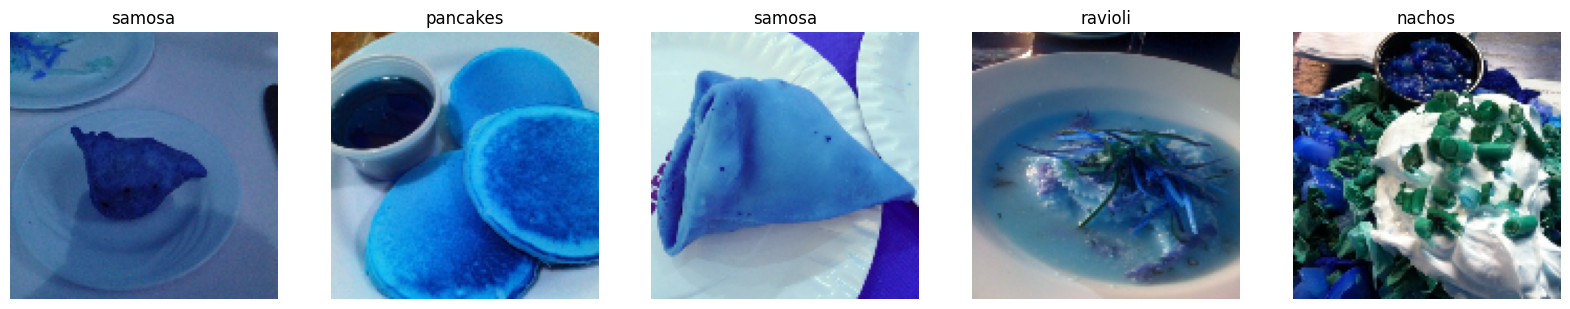

In [11]:
# visualizing the random images in the dataset along with their labels

rand = np.random.randint(0, len(X), 5) # Generating 10 random numbers out of total number of foods
print(rand)
plt.figure(figsize=(20, 15))
for i,j in enumerate(rand):
    plt.subplot(1, len(rand), i+1)
    plt.imshow(X[j])  # greens, reds, blues, rgb
    plt.title("{}".format(y[j]))
    plt.axis('off')
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=28, stratify=y)
print(len(X_train))
print(len(X_test))

5400
600


In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=28, stratify=y_train)
print(len(X_train))
print(len(X_val))

3780
1620


In [15]:
## One hot encode the target variable
y_train = pd.get_dummies(y_train).values
y_val = pd.get_dummies(y_val).values
y_test = pd.get_dummies(y_test).values

## Convert data from list to array
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

In [19]:
## Normalization
X_train = np.array(X_train).astype('float')
# X_train = X_train.reshape(X_train.shape[0],128,128,3)
X_train = X_train / 255                                          

X_val = np.array(X_val).astype('float')
# X_val = X_val.reshape(X_val.shape[0],128,128,3)
X_val = X_val / 255

X_test = np.array(X_test).astype('float')
# X_test = X_test.reshape(X_test.shape[0],128,128,3)
X_test = X_test / 255

In [20]:
## Check the min and max values after normalization
print('Train data------------','max:',X_train.max(), 'min:',X_train.min())
print('Validation data-------','max:',X_val.max(), 'min:',X_val.min())
print('Test data-------','max:',X_test.max(), 'min:',X_test.min())

Train data------------ max: 1.0 min: 0.0
Validation data------- max: 1.0 min: 0.0
Test data------- max: 1.0 min: 0.0


In [21]:
# DATA SET SHAPE AND SIZE
print('\nTraining data : ', X_train.shape, np.array(y_train).shape)  # TRAIN
print('\nValidation data : ', X_val.shape, np.array(y_val).shape)       # Validation
print('\nTesting data : ', X_test.shape, np.array(y_test).shape)       # Test


Training data :  (3780, 128, 128, 3) (3780, 6)

Validation data :  (1620, 128, 128, 3) (1620, 6)

Testing data :  (600, 128, 128, 3) (600, 6)


# VGG16 Model

In [22]:
# Optimized Vgg16

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = VGG16(input_shape=X_train[0].shape,
                   weights='imagenet',
                   include_top=False) #imports the VGG16 model and discards the last 1000 neuron layer.

x = base_model.output
x = GlobalAveragePooling2D()(x) # Optional

x = Dropout(0.2)(x)
x = Dense(512, kernel_initializer=HeUniform(seed=13), kernel_regularizer= tensorflow.keras.regularizers.l2(0.0001), activation='relu')(x) 
x = BatchNormalization(momentum=0.99)(x)
x = Dropout(0.1)(x)
x = Dense(256, kernel_initializer=HeUniform(seed=13), kernel_regularizer= tensorflow.keras.regularizers.l2(0.0001), activation='relu')(x) 
x = BatchNormalization(momentum=0.99)(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation='softmax')(x) #final layer with softmax activation

model_vgg16 = Model(inputs=base_model.input,
                    outputs=preds)

# set the first 20 layers of the network to be non-trainable
for layer in model_vgg16.layers[:20]:
    layer.trainable=False
for layer in model_vgg16.layers[20:]:
    layer.trainable=True

# Compile the model
model_vgg16.compile(optimizer='Adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_vgg16.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [23]:
tr_history = model_vgg16.fit(x=X_train, 
                              y=y_train, 
                              batch_size=64, 
                              epochs=15, 
                              validation_data=(X_val, y_val))

Epoch 1/15
60/60 [==============================] - 25s 166ms/step - loss: 1.5545 - accuracy: 0.5177 - val_loss: 1.2701 - val_accuracy: 0.6414
Epoch 2/15
60/60 [==============================] - 7s 123ms/step - loss: 1.1612 - accuracy: 0.6439 - val_loss: 1.0536 - val_accuracy: 0.7056
Epoch 3/15
60/60 [==============================] - 7s 115ms/step - loss: 1.0476 - accuracy: 0.6767 - val_loss: 1.0483 - val_accuracy: 0.6685
Epoch 4/15
60/60 [==============================] - 7s 116ms/step - loss: 1.0290 - accuracy: 0.6825 - val_loss: 0.9759 - val_accuracy: 0.6994
Epoch 5/15
60/60 [==============================] - 7s 117ms/step - loss: 0.9766 - accuracy: 0.6997 - val_loss: 0.9227 - val_accuracy: 0.7284
Epoch 6/15
60/60 [==============================] - 8s 127ms/step - loss: 0.9570 - accuracy: 0.7140 - val_loss: 0.9323 - val_accuracy: 0.7247
Epoch 7/15
60/60 [==============================] - 7s 118ms/step - loss: 0.9038 - accuracy: 0.7347 - val_loss: 0.9142 - val_accuracy: 0.7444
Epoch

Text(0.5, 1.0, 'Training and validation loss')

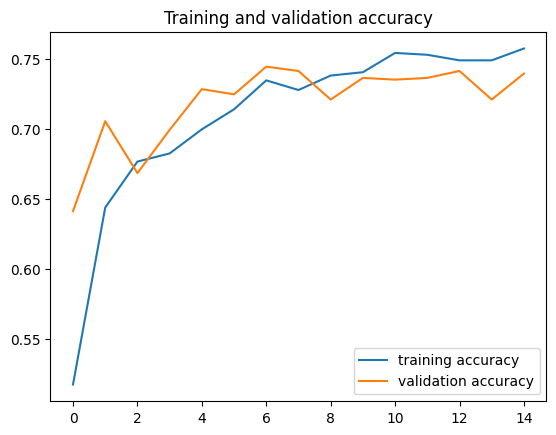

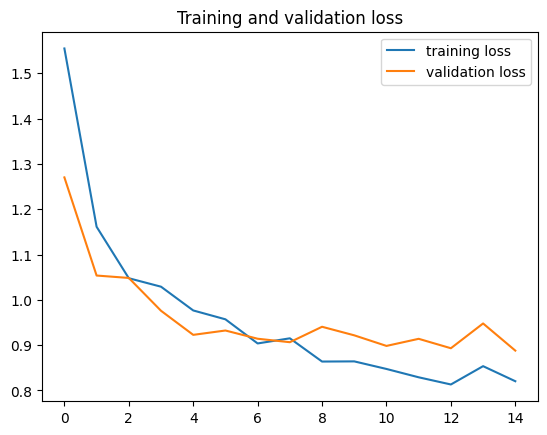

In [24]:
## Accuracy and Loss plots

accuracy = tr_history.history['accuracy']
val_accuracy = tr_history.history['val_accuracy']
loss = tr_history.history['loss']
val_loss = tr_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

In [25]:
# Saving model weights

model_vgg16.save('vgg16.h5')
model_vgg16.save_weights('vgg16_weights.h5')

# Inception V3 Model

In [26]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

# Load the InceptionV3 model without the top (fully connected layers)
base_model = InceptionV3(input_shape=X_train[0].shape, weights='imagenet', include_top=False)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x) # Optional

x = Dropout(0.3)(x)
x = Dense(128, kernel_initializer=HeUniform(seed=13), kernel_regularizer= tensorflow.keras.regularizers.l2(0.0001), activation='relu')(x) 
x = BatchNormalization(momentum=0.9)(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation='softmax')(x) #final layer with softmax activation

model_inceptionV3 = Model(inputs=base_model.input,
                    outputs=preds)

87910968/87910968 [==============================] - 4s 0us/step


In [27]:
# Compile the model
model_inceptionV3.compile(optimizer='Adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_inceptionV3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 rmalization)                                                                                     
                                                                                            

In [28]:
# train the model
tr_history = model_inceptionV3.fit(x=X_train, 
                              y=y_train, 
                              batch_size=32, 
                              epochs=10, 
                              validation_data=(X_val, y_val))

Epoch 1/10
119/119 [==============================] - 16s 75ms/step - loss: 1.2502 - accuracy: 0.5791 - val_loss: 0.9366 - val_accuracy: 0.6988
Epoch 2/10
119/119 [==============================] - 6s 50ms/step - loss: 0.8697 - accuracy: 0.6966 - val_loss: 0.9123 - val_accuracy: 0.6938
Epoch 3/10
119/119 [==============================] - 5s 40ms/step - loss: 0.8055 - accuracy: 0.7220 - val_loss: 0.8723 - val_accuracy: 0.7068
Epoch 4/10
119/119 [==============================] - 6s 52ms/step - loss: 0.7244 - accuracy: 0.7534 - val_loss: 0.8598 - val_accuracy: 0.7130
Epoch 5/10
119/119 [==============================] - 6s 50ms/step - loss: 0.6958 - accuracy: 0.7632 - val_loss: 0.8478 - val_accuracy: 0.7167
Epoch 6/10
119/119 [==============================] - 5s 43ms/step - loss: 0.6704 - accuracy: 0.7680 - val_loss: 0.8819 - val_accuracy: 0.7049
Epoch 7/10
119/119 [==============================] - 5s 40ms/step - loss: 0.6649 - accuracy: 0.7812 - val_loss: 0.8895 - val_accuracy: 0.703

Text(0.5, 1.0, 'Training and validation loss')

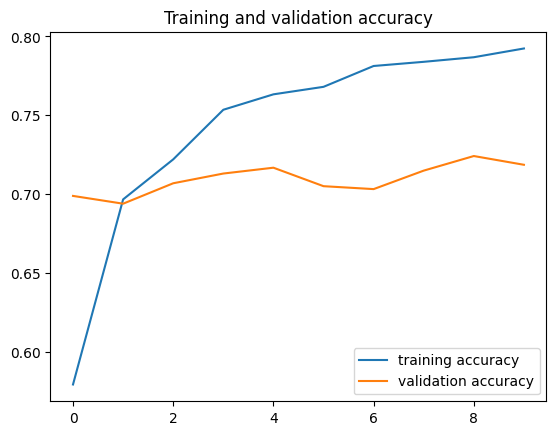

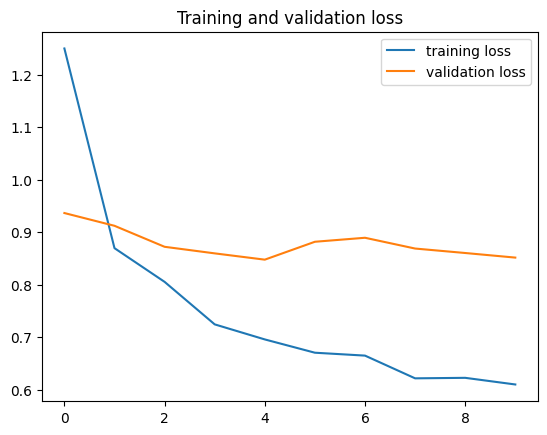

In [29]:
## Accuracy and Loss plots

accuracy = tr_history.history['accuracy']
val_accuracy = tr_history.history['val_accuracy']
loss = tr_history.history['loss']
val_loss = tr_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

# EffNet B0 Model

In [30]:
X_train[0].shape # For EffNetB0 we need to give (224,224) input size of image but due to limited resources we only gave 128,128 size

(128, 128, 3)

In [31]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

# Create an instance of the EfficientNetB0 model
base_model = EfficientNetB0(input_shape=X_train[0].shape, weights='imagenet', include_top=False)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x) # Optional

x = Dropout(0.1)(x)
x = Dense(1024, kernel_initializer=HeUniform(seed=14), kernel_regularizer= tensorflow.keras.regularizers.l2(0.0001), activation='relu')(x) #dense layer 3
x = BatchNormalization(momentum=0.99)(x)
x = Dropout(0.1)(x)
x = Dense(512, kernel_initializer=HeUniform(seed=14), kernel_regularizer= tensorflow.keras.regularizers.l2(0.0001), activation='relu')(x) #dense layer 3
x = BatchNormalization(momentum=0.99)(x)
x = Dropout(0.1)(x)

preds = Dense(6, activation='softmax')(x) #final layer with softmax activation

model_EfficientNetB0 = Model(inputs=base_model.input,
                    outputs=preds)

16705208/16705208 [==============================] - 1s 0us/step


In [32]:
# Compile the model
model_EfficientNetB0.compile(optimizer='Adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_EfficientNetB0.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 128, 128, 3)  0           ['normalization[0][0]']    

In [33]:
# train the model
tr_history = model_EfficientNetB0.fit(x=X_train, 
                              y=y_train, 
                              batch_size=32, 
                              epochs=10, 
                              validation_data=(X_val, y_val))

Epoch 1/10
119/119 [==============================] - 18s 75ms/step - loss: 2.7276 - accuracy: 0.1675 - val_loss: 2.1255 - val_accuracy: 0.1660
Epoch 2/10
119/119 [==============================] - 4s 38ms/step - loss: 2.3651 - accuracy: 0.1749 - val_loss: 2.0997 - val_accuracy: 0.1667
Epoch 3/10
119/119 [==============================] - 5s 38ms/step - loss: 2.2242 - accuracy: 0.1706 - val_loss: 2.0712 - val_accuracy: 0.1667
Epoch 4/10
119/119 [==============================] - 4s 36ms/step - loss: 2.1883 - accuracy: 0.1743 - val_loss: 2.1053 - val_accuracy: 0.1698
Epoch 5/10
119/119 [==============================] - 4s 38ms/step - loss: 2.1672 - accuracy: 0.1685 - val_loss: 2.0699 - val_accuracy: 0.1691
Epoch 6/10
119/119 [==============================] - 4s 38ms/step - loss: 2.1463 - accuracy: 0.1606 - val_loss: 2.0657 - val_accuracy: 0.1660
Epoch 7/10
119/119 [==============================] - 4s 37ms/step - loss: 2.1155 - accuracy: 0.1886 - val_loss: 2.0478 - val_accuracy: 0.165

Text(0.5, 1.0, 'Training and validation loss')

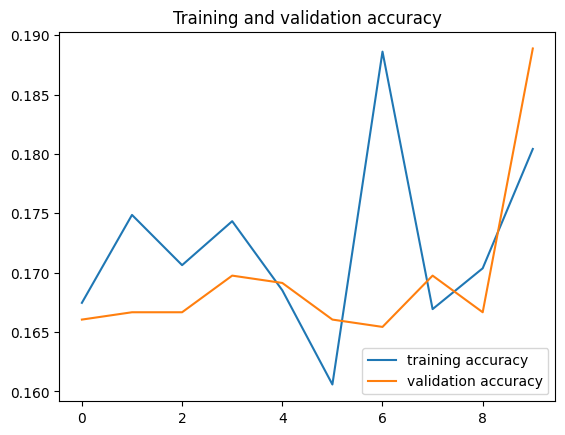

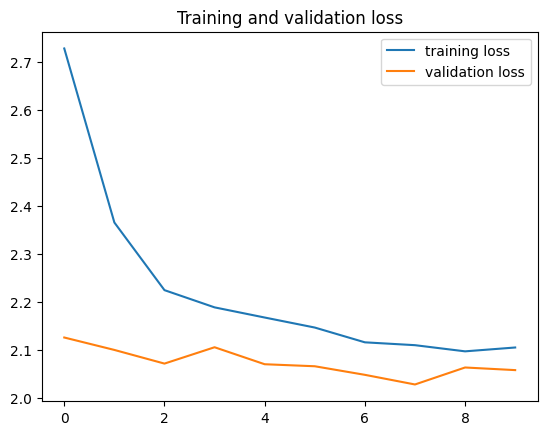

In [34]:
## Accuracy and Loss plots

accuracy = tr_history.history['accuracy']
val_accuracy = tr_history.history['val_accuracy']
loss = tr_history.history['loss']
val_loss = tr_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

# MobileNet Model

In [35]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model

# Create an instance of the EfficientNetB0 model
base_model = MobileNet(input_shape=X_train[0].shape, weights='imagenet', include_top=False)

base_model.trainable = False

x = base_model.output
# x = GlobalAveragePooling2D()(x)
x = GlobalMaxPooling2D()(x) # Optional

x = Dropout(0.2)(x)
x = Dense(512, kernel_initializer=HeUniform(seed=13), kernel_regularizer= tensorflow.keras.regularizers.l2(0.0001), activation='relu')(x) 
x = BatchNormalization(momentum=0.99)(x)
x = Dropout(0.1)(x)
x = Dense(256, kernel_initializer=HeUniform(seed=13), kernel_regularizer= tensorflow.keras.regularizers.l2(0.0001), activation='relu')(x) 
x = BatchNormalization(momentum=0.99)(x)
x = Dropout(0.1)(x)

preds = Dense(6, activation='softmax')(x) #final layer with softmax activation

model_MobileNet = Model(inputs=base_model.input,
                    outputs=preds)

17225924/17225924 [==============================] - 1s 0us/step


In [36]:
# Compile the model
from tensorflow.keras.optimizers import Adam

model_MobileNet.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_MobileNet.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                    

In [37]:
# train the model
tr_history = model_MobileNet.fit(x=X_train, 
                              y=y_train, 
                              batch_size=64, 
                              epochs=15, 
                              validation_data=(X_val, y_val))

Epoch 1/15
60/60 [==============================] - 8s 72ms/step - loss: 1.9345 - accuracy: 0.3767 - val_loss: 1.2865 - val_accuracy: 0.6000
Epoch 2/15
60/60 [==============================] - 3s 50ms/step - loss: 1.2390 - accuracy: 0.6101 - val_loss: 0.9533 - val_accuracy: 0.7204
Epoch 3/15
60/60 [==============================] - 3s 42ms/step - loss: 1.0462 - accuracy: 0.6854 - val_loss: 0.8713 - val_accuracy: 0.7469
Epoch 4/15
60/60 [==============================] - 3s 42ms/step - loss: 0.9474 - accuracy: 0.7220 - val_loss: 0.8214 - val_accuracy: 0.7648
Epoch 5/15
60/60 [==============================] - 2s 39ms/step - loss: 0.8891 - accuracy: 0.7455 - val_loss: 0.7953 - val_accuracy: 0.7802
Epoch 6/15
60/60 [==============================] - 2s 39ms/step - loss: 0.8441 - accuracy: 0.7619 - val_loss: 0.7817 - val_accuracy: 0.7852
Epoch 7/15
60/60 [==============================] - 2s 39ms/step - loss: 0.7928 - accuracy: 0.7722 - val_loss: 0.7625 - val_accuracy: 0.7901
Epoch 8/15
60

Text(0.5, 1.0, 'Training and validation loss')

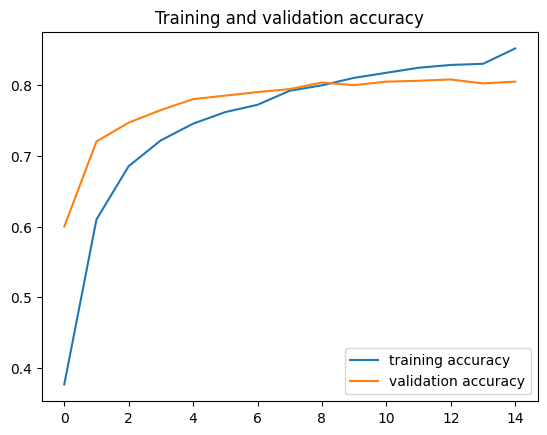

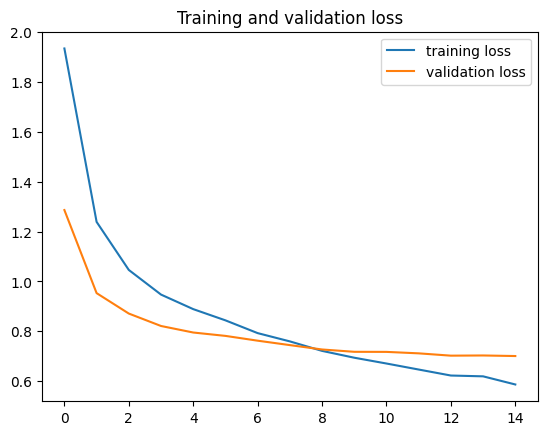

In [38]:
## Accuracy and Loss plots

accuracy = tr_history.history['accuracy']
val_accuracy = tr_history.history['val_accuracy']
loss = tr_history.history['loss']
val_loss = tr_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

In [39]:
# Performance Metrics

from sklearn.metrics import classification_report, confusion_matrix

y_pred = model_MobileNet.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels
y_test = np.argmax(y_test, axis=1)  # Convert actual probabilities to class labels

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

19/19 [==============================] - 1s 24ms/step
Confusion Matrix:
[[92  1  1  0  0  6]
 [ 3 82  2  5  7  1]
 [ 4  3 82  4  1  6]
 [ 1  8  4 81  5  1]
 [ 1  8 10 10 67  4]
 [ 3  3  3  0  2 89]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       100
           1       0.78      0.82      0.80       100
           2       0.80      0.82      0.81       100
           3       0.81      0.81      0.81       100
           4       0.82      0.67      0.74       100
           5       0.83      0.89      0.86       100

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600



In [40]:
# import os
# cwd = os.getcwd()  # ----> Get the current working directory
# print(cwd)

# Saving the model 
model_MobileNet.save('/content/gdrive/MyDrive/Capstone_Project/capstone_mobilenet_final.h5')

# Load the saved model 
loaded_model = tensorflow.keras.models.load_model('/content/gdrive/MyDrive/Capstone_Project/capstone_mobilenet_final.h5') 

# Conclusions:
- We can observe that MobileNet is performing the best with test accuracy of 82% and average f1-score of 0.82
- The accuracy and loss curves are also quite stable and smooth while training the model.